# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset file of current TKL

In [3]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for AAPL .....


df for training
-----------------


,Date,y_next,y_min_5,y_pct_5,y_mean_22,NASDAQ,Oil,NASDAQ_max_65,y_min_22,y,y_diff_10,y_std_5,y_diff_5,y_min_65,Gold,y_diff_22
4821,2025-12-05,0.970774,0.973908,-0.000253,0.95812,0.983237,0.534168,1.0,0.929787,0.973908,0.044121,0.010227,-0.000247,0.790067,0.96719,0.031696



df for visualization
----------------------


,Date,y_min_5_orig,y_pct_5_orig,y_mean_22_orig,NASDAQ_orig,Oil_orig,NASDAQ_max_65_orig,y_min_22_orig,y_orig,y_diff_10_orig,y_std_5_orig,y_diff_5_orig,y_min_65_orig,Gold_orig,y_diff_22_orig,y_next_orig
4821,2025-12-05,278.779999,-0.000251,274.296233,23578.130859,60.080002,23958.470703,266.25,278.779999,12.529999,2.90438,-0.070007,226.570358,4212.899902,9.001526,277.890015


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822 entries, 0 to 4821
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           4822 non-null   object 
 1   y_next         4822 non-null   float64
 2   y_min_5        4822 non-null   float64
 3   y_pct_5        4822 non-null   float64
 4   y_mean_22      4822 non-null   float64
 5   NASDAQ         4822 non-null   float64
 6   Oil            4822 non-null   float64
 7   NASDAQ_max_65  4822 non-null   float64
 8   y_min_22       4822 non-null   float64
 9   y              4822 non-null   float64
 10  y_diff_10      4822 non-null   float64
 11  y_std_5        4822 non-null   float64
 12  y_diff_5       4822 non-null   float64
 13  y_min_65       4822 non-null   float64
 14  Gold           4822 non-null   float64
 15  y_diff_22      4822 non-null   float64
dtypes: float64(15), object(1)
memory usage: 602.9+ KB


# LSTM

## Data prep

In [5]:
def make_datasets(df,X_cols, y_col, look_back_days):
    X, y = [], []
    for i in range(look_back_days, len(df)):
        X.append(df.loc[i-look_back_days:i-1, X_cols].values)
        y.append(df.loc[i, y_col].values[0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    split = int(0.9 * len(X))

    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    dates_test = df.loc[split: , 'Date'].values
    dates_test = pd.to_datetime(dates_test)

    return X, y, X_train, X_test, y_train, y_test, dates_test

In [6]:
def train_predict(X, y, X_train, X_test, y_train, y_test, dates_test, model='LSTM', epochs=20, batch_size=32):

  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import LSTM, Dense, GRU

  if model == 'LSTM':
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X.shape[1],X.shape[2])),
        LSTM(10),
        Dense(1)
    ])

  if model == 'GRU':
    model = Sequential([
      GRU(50, return_sequences=True, input_shape=(X.shape[1],X.shape[2])),
      GRU(10),
      Dense(1)
    ])

  model.compile(optimizer='adam', loss='mse')

  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

  pred = model.predict(X_test)

  # Calculate min and max for 'y_next' from the original unscaled data (df_orig)
  # This allows us to manually inverse transform the single predicted value.
  min_y_next_orig = df_orig['y_next_orig'].min()
  max_y_next_orig = df_orig['y_next_orig'].max()

  # Inverse transform the scaled prediction using the min-max formula
  unscaled_prediction = pred * (max_y_next_orig - min_y_next_orig) + min_y_next_orig
  unscaled_y_test = y_test * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

  return unscaled_prediction, unscaled_y_test, dates_test

In [7]:
def plot_results(unscaled_prediction, unscaled_y_test, dates_test, x_features='all', model='LSTM'):

  plt.figure(figsize=(12,6))

  # Ensure all arrays have the same length for plotting
  # Truncate dates_test and unscaled_y_test to match unscaled_prediction's length
  N = len(y_test)
  dates_test_trimmed = dates_test[-N:]
  unscaled_y_test_trimmed = unscaled_y_test[-N:]

  plt.plot(dates_test_trimmed, unscaled_y_test, label=f"{project_config['TKL']} price, Actual")
  plt.plot(dates_test_trimmed, unscaled_prediction, label=f"{project_config['TKL']} price, Predicted")

  plt.title(f"{model}. X features = {x_features}")

  # MONTHLY ticks
  import matplotlib.dates as mdates
  ax = plt.gca()
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

  plt.xticks(rotation=45)
  plt.tight_layout()

  plt.legend()
  plt.show()

In [8]:
LOOK_BACK_DAYS = 66

In [9]:
X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = [col for col in df.columns if '_' not in col and col != 'Date']
X_cols_tkl =  ['y']

y_col =  ['y_next']

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0043
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 9.1513e-05
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 1.2389e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 6.9725e-05
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 6.9709e-05
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 7.6142e-05
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 6.9290e-05
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 6.9342e-05
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 6.9571e-05
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 7.3942e-05
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 7.6708e-05
Epoch 12/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 6.2606e-05
Epoch 13/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 7.1294e-05
Epoch 14/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 

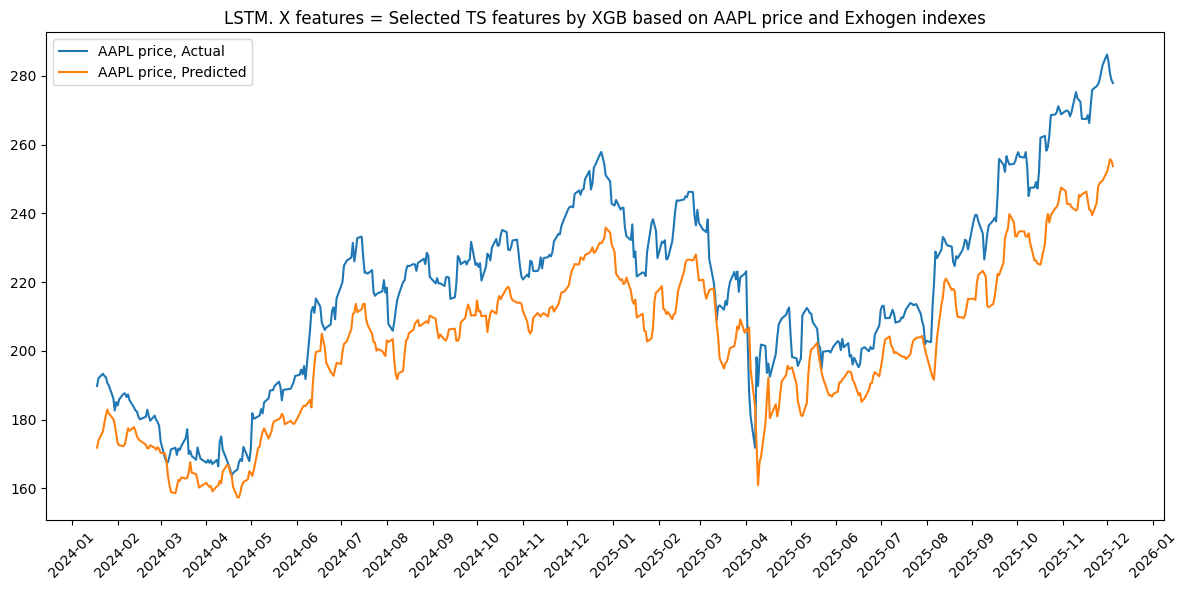

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 0.0064
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.2870e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 7.4884e-05
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 6.8995e-05
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 6.8601e-05
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 7.3905e-05
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 6.4525e-05
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 5.7657e-05
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 5.8613e-05
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 5.8076e-05
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 6.1906e-05
Epoch 12/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 6.6053e-05
Epoch 13/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 6.3713e-05
Epoch 14/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 5

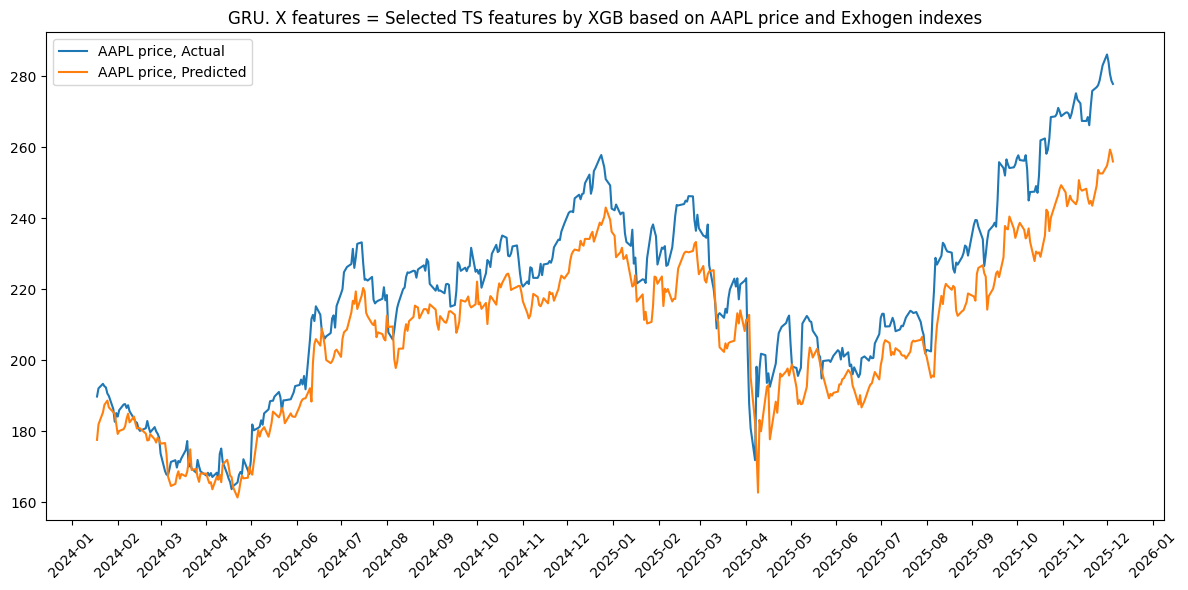

In [ ]:
for X_cols in [X_cols_full, X_cols_exho, X_cols_tkl]:

  if X_cols == X_cols_full: X_features = f"Selected TS features by XGB based on {project_config['TKL']} price and Exhogen indexes"
  if X_cols == X_cols_exho: X_features = f"{project_config['TKL']} price + Exhogen indexes"
  if X_cols == X_cols_tkl: X_features = f"{project_config['TKL']} price"

  for model in ['LSTM', 'GRU']:

    X, y, X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col, LOOK_BACK_DAYS)
    unscaled_prediction, unscaled_y_test, dates_test = train_predict(X, y, X_train, X_test, y_train, y_test, dates_test, model=model, epochs=20, batch_size=32)
    plot_results(unscaled_prediction, unscaled_y_test, dates_test, x_features=X_features, model=model)

In [ ]:
# X, y, X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col, LOOK_BACK_DAYS)

In [ ]:
# unscaled_prediction, unscaled_y_test, dates_test = train_predict(X, y, X_train, X_test, y_train, y_test, dates_test, model='LSTM', epochs=20, batch_size=32)

In [ ]:
# plot_results(unscaled_prediction, unscaled_y_test, dates_test, x_features=f"{project_config['TKL']} price", model='LSTM')

In [ ]:
# X, y = [], []

# for i in range(LOOK_BACK_DAYS, len(df)):

#     # Ensure X elements are numerical arrays
#     X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)

#     # Extract the scalar float value from the 1-element array
#     y.append(df.loc[i, y_col].values[0])


# # Explicitly cast to float32 to ensure correct dtype for Keras
# X = np.array(X, dtype=np.float32)
# y = np.array(y, dtype=np.float32)

# X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) # Reshape X for LSTM input

In [ ]:
# split = int(0.9 * len(X))

# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

# dates_test = df.loc[split: , 'Date'].values
# dates_test = pd.to_datetime(dates_test)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, GRU

# model = Sequential([
#     GRU(50, return_sequences=True, input_shape=(X.shape[1],X.shape[2])),
#     GRU(10),
#     Dense(1)
# ])

# model.compile(optimizer='adam', loss='mse')

# history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# pred = model.predict(X_test)

In [ ]:
# # Calculate min and max for 'y_next' from the original unscaled data (df_orig)
# # This allows us to manually inverse transform the single predicted value.
# min_y_next_orig = df_orig['y_next_orig'].min()
# max_y_next_orig = df_orig['y_next_orig'].max()

# # Inverse transform the scaled prediction using the min-max formula
# unscaled_prediction = pred * (max_y_next_orig - min_y_next_orig) + min_y_next_orig
# unscaled_y_test = y_test * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

In [ ]:
# plt.figure(figsize=(12,6))

# # Ensure all arrays have the same length for plotting
# # Truncate dates_test and unscaled_y_test to match unscaled_prediction's length
# N = len(y_test)
# dates_test_trimmed = dates_test[-N:]
# unscaled_y_test_trimmed = unscaled_y_test[-N:]

# plt.plot(dates_test_trimmed, unscaled_y_test, label="Actual")
# plt.plot(dates_test_trimmed, unscaled_prediction, label="Predicted")

# plt.title("LSTM Forecast – Actual vs Predicted")
# plt.xlabel("Date")
# plt.ylabel("Value")

# # MONTHLY ticks
# import matplotlib.dates as mdates
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plt.xticks(rotation=45)
# plt.tight_layout()

# plt.legend()
# plt.show()